In [1]:
import importlib

import common

importlib.reload(common)

<module 'common' from 'C:\\Users\\j\\IdeaProjects\\fiit_masters_thesis_project\\jupyter\\common.py'>

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

from common import create_engine
from common import display_all
from common import figsize
from common import save_df


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # converters e.g. for datetime in plots

In [3]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sqlalchemy.text(sql), con=engine)

Nacitanie dat z db (live data z monant snapshotu)

In [4]:
create_view_query = '''
DROP MATERIALIZED VIEW IF EXISTS article_fb_latest;
CREATE MATERIALIZED VIEW article_fb_latest AS
(
SELECT sbq.url, sbq.sync_date, sbq.reaction_count, sbq.comment_count, sbq.share_count
FROM (
         SELECT afe.*, row_number() OVER (PARTITION BY url ORDER BY sync_date DESC) as rn
         FROM article_fb_engagement afe
     ) sbq
WHERE sbq.rn = 1)
'''

with engine.connect() as connection:
    connection.execute(create_view_query)

In [6]:
fetch_data_query = '''
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       published_at,
       extracted_at,
       a.source_id,
       category,
       other_info,
       coalesce(imgc.cnt, 0)                          as image_count,
       coalesce(vidc.cnt, 0)                          as video_count,
       aut.name                                       as author_name,
       s.id                                           as source_id,
       s.name                                         as source_name,
       s.url                                          as source_url,
       stype                                          as source_type,
       is_reliable::integer                           as source_is_reliable,
       sync_date                                      as fb_sync_date,
       reaction_count                                 as fb_reaction_count,
       comment_count                                  as fb_comment_count,
       share_count                                    as fb_share_count,
       (reaction_count + comment_count + share_count) as fb_popularity
FROM article a
         JOIN source s on a.source_id = s.id
         JOIN (SELECT * FROM article_fb_latest) p ON a.url = p.url
         JOIN author aut on a.author_id = aut.id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'image' GROUP BY article_id) imgc
                   ON a.id = imgc.article_id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'video' GROUP BY article_id) vidc
                   ON a.id = vidc.article_id
WHERE s.url !~ '(\.sk$)|(\.cz$)' -- remove cz/sk sources
  AND s.name NOT IN ('badatel.net', -- cz/sk portals not using cz/sk domain
                     'energiezivota.com')
  AND a.published_at IS NOT NULL
  AND s.is_reliable IS NOT NULL;
'''

df = pd.sql(fetch_data_query)
df_copy = df.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171744 entries, 0 to 171743
Data columns (total 23 columns):
id                    171744 non-null int64
url                   171744 non-null object
title                 171744 non-null object
perex                 147554 non-null object
body                  171511 non-null object
published_at          171744 non-null datetime64[ns]
extracted_at          171744 non-null datetime64[ns]
source_id             171744 non-null int64
category              143718 non-null object
other_info            171740 non-null object
image_count           171744 non-null int64
video_count           171744 non-null int64
author_name           171744 non-null object
source_id             171744 non-null int64
source_name           171744 non-null object
source_url            171744 non-null object
source_type           171744 non-null object
source_is_reliable    171744 non-null int64
fb_sync_date          171744 non-null datetime64[ns]
fb_reaction_coun

In [8]:
df.head()

,id,url,title,perex,body,published_at,extracted_at,source_id,category,other_info,...,source_id,source_name,source_url,source_type,source_is_reliable,fb_sync_date,fb_reaction_count,fb_comment_count,fb_share_count,fb_popularity
0,235048,https://www.naturalnewsblogs.com/the-secret-to...,The Secret to Happiness &#8211; Revealed!,<p>&#8220;Why are you so happy all of the time...,“Why are you so happy all of the time?”\nI am ...,2013-08-07 12:36:20,2019-09-05 06:45:28.429274,142,"[Health, Mental Health]","{'tags': ['choices', 'depression', 'happiness'...",...,142,naturalnewsblogs.com,http://naturalnewsblogs.com,news_website,0,2019-10-14 15:29:44.601408,0,0,0,0
1,235036,https://www.naturalnewsblogs.com/us-government...,US government claims 100% ownership over all y...,<p>(NaturalNews) The United States government ...,(NaturalNews) The United States government cla...,2013-05-19 18:50:37,2019-09-05 06:45:27.633650,142,"[Health, News, Science, Weird, Biotechnology, ...","{'tags': ['gene patents', 'genetic slavery', '...",...,142,naturalnewsblogs.com,http://naturalnewsblogs.com,news_website,0,2019-10-14 15:29:44.601408,0,0,0,0
2,235039,https://www.naturalnewsblogs.com/angelina-joli...,Angelina Jolie copied by men! Surgeons now cut...,<p>(NaturalNews) Beyond merely inspiring women...,(NaturalNews) Beyond merely inspiring women to...,2013-05-20 18:54:30,2019-09-05 06:45:28.083048,142,"[Health, Science, Weird, Celebrity, Hospitals ...","{'tags': ['Angelina Jolie', 'BRCA genes', 'pro...",...,142,naturalnewsblogs.com,http://naturalnewsblogs.com,news_website,0,2019-10-14 15:29:44.601408,0,0,0,0
3,235041,https://www.naturalnewsblogs.com/natural-news-...,Natural News releases latest laboratory test r...,"<p>(NaturalNews) As Natural News readers know,...","(NaturalNews) As Natural News readers know, we...",2013-05-23 19:47:30,2019-09-05 06:45:28.167110,142,"[Health, Food, Nutrition]","{'tags': ['clean chlorella', 'heavy metals', '...",...,142,naturalnewsblogs.com,http://naturalnewsblogs.com,news_website,0,2019-10-14 15:29:44.601408,0,0,0,0
4,235052,https://www.naturalnewsblogs.com/food-insecuri...,Food Insecurity: A Solution Grows Under Your Feet,<p>Food insecurity is a serious problem that p...,Food insecurity is a serious problem that plag...,2013-08-08 10:12:31,2019-09-05 06:45:28.607943,142,"[Health, Nutritional Medicine, Food, Nutrition]","{'tags': ['broadleaf plantain', 'food insecuri...",...,142,naturalnewsblogs.com,http://naturalnewsblogs.com,news_website,0,2019-10-14 15:29:44.601408,0,0,0,0


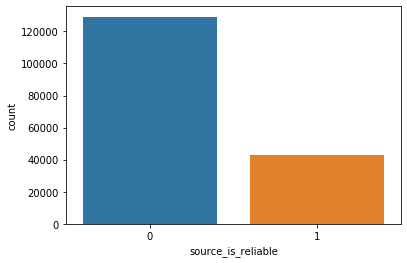

In [9]:
sns.countplot(x='source_is_reliable', data=df)

In [10]:
df['fb_popularity'].describe().apply(lambda x: '%.3f' % x)

count     171744.000
mean        1357.927
std        26600.376
min            0.000
25%            0.000
50%            1.000
75%           94.000
max      5197586.000
Name: fb_popularity, dtype: object

In [11]:
def draw_publishing_per_year(df):
    published_in_year = df.published_at.apply(lambda x: x.year)
    with figsize(plt, 20, 5):
        cplt = sns.countplot(published_in_year, color='black')
        cplt.set(xlabel='Rok publikovania', ylabel='Počet článkov')
        return cplt


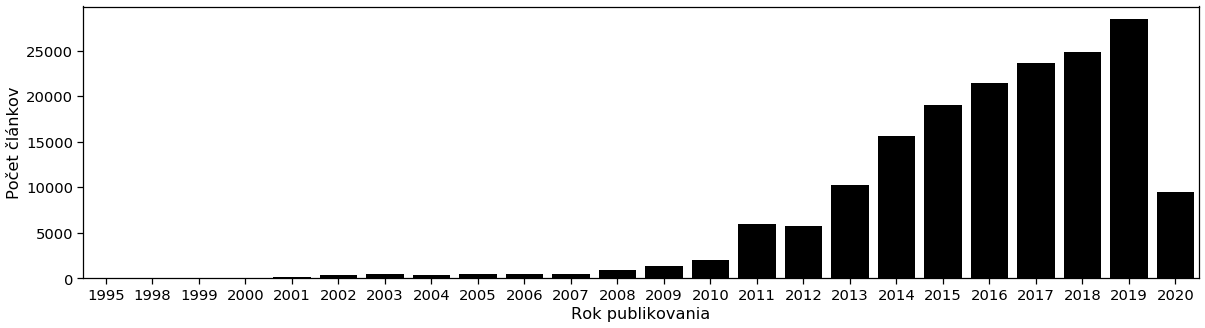

In [12]:
with sns.plotting_context("notebook", font_scale=1.35):
    draw_publishing_per_year(df).get_figure().savefig('export/clanky-per-rok.png')

Cut the articles so we use only those from 2011 - now

In [13]:
df = df[df.published_at > '2011-01-01']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164450 entries, 0 to 171743
Data columns (total 23 columns):
id                    164450 non-null int64
url                   164450 non-null object
title                 164450 non-null object
perex                 140260 non-null object
body                  164221 non-null object
published_at          164450 non-null datetime64[ns]
extracted_at          164450 non-null datetime64[ns]
source_id             164450 non-null int64
category              136428 non-null object
other_info            164446 non-null object
image_count           164450 non-null int64
video_count           164450 non-null int64
author_name           164450 non-null object
source_id             164450 non-null int64
source_name           164450 non-null object
source_url            164450 non-null object
source_type           164450 non-null object
source_is_reliable    164450 non-null int64
fb_sync_date          164450 non-null datetime64[ns]
fb_reaction_coun

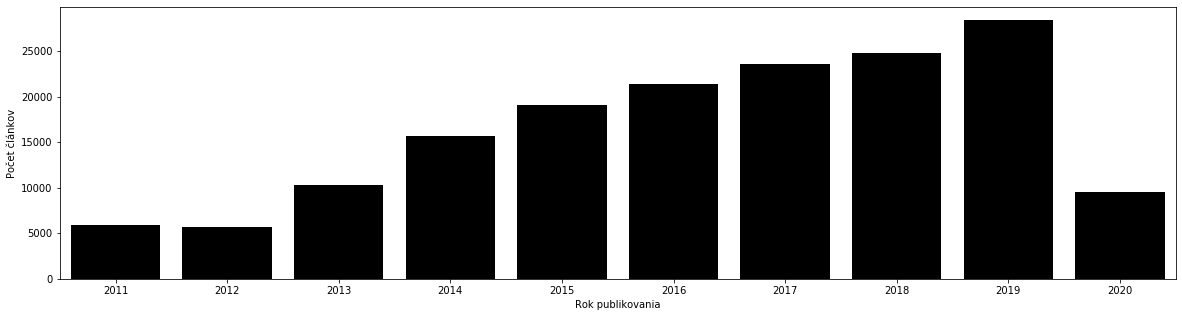

In [15]:
draw_publishing_per_year(df)

In [16]:
df[['source_name', 'source_is_reliable']].groupby('source_name').first()['source_is_reliable'].value_counts()

0    47
1    20
Name: source_is_reliable, dtype: int64

In [17]:
display_all(df[['source_is_reliable', 'fb_reaction_count', 'fb_comment_count', 'fb_share_count']] .groupby('source_is_reliable').describe())

fb_reaction_count                                       \
                               count         mean           std  min  25%   
source_is_reliable                                                          
0                           123051.0  1108.318413  22455.644970  0.0  0.0   
1                            41399.0   408.325805   7463.737583  0.0  0.0   

                                         fb_comment_count              \
                    50%   75%        max            count        mean   
source_is_reliable                                                      
0                   0.0  54.0  3929532.0         123051.0  229.554973   
1                   0.0  51.0  1259379.0          41399.0  122.386531   

                                                              fb_share_count  \
                            std  min  25%  50%  75%       max          count   
source_is_reliable                                                             
0                   4509.561130  0.0  0.0  0.0  8.0  714968.0       123051.0   
1                   4105.645533  0.0  0.0  0.0  7.0  797490.0        41399.0   

                                                                            
                          mean          std  min  25%  50%   75%       max  
source_is_reliable                                                          
0                   328.223525  4836.403253  0.0  0.0  1.0  37.0  572708.0  
1                   138.787048  1851.004532  0.0  0.0  1.0  30.0  282580.0

In [18]:
df_gb_pop = df.groupby('source_url')['fb_popularity'].describe().sort_values('count', ascending=False)
df_gb_pop['is_reliable'] = df.groupby('source_url')['source_is_reliable'].first()
display_all(df_gb_pop)

,count,mean,std,min,25%,50%,75%,max,is_reliable
source_url,,,,,,,,,
http://naturalnews.com,23247.0,1142.865402,39220.523616,0.0,22.00,84.0,241.00,5197586.0,0
http://naturalnewsblogs.com,17774.0,86.827445,2293.512311,0.0,0.00,0.0,1.00,203855.0,0
http://neurosciencenews.com,13775.0,304.632958,3981.931552,0.0,0.00,0.0,87.00,294411.0,1
http://statnews.com,13203.0,258.860562,2127.504594,0.0,0.00,0.0,37.50,83695.0,1
http://healthnutnews.com,7614.0,1619.963226,22942.423613,0.0,4.00,205.0,775.00,1810067.0,0
http://naturalsociety.com,7250.0,10.417931,602.752769,0.0,0.00,0.0,0.00,49319.0,0
http://healthimpactnews.com,6420.0,369.477570,10767.953962,0.0,0.00,0.0,12.00,841807.0,0
http://themindunleashed.com,6203.0,9912.953893,64944.903258,0.0,0.00,67.0,2119.50,1858055.0,0
http://infowars.com,5992.0,55.926903,387.186395,0.0,0.00,0.0,10.00,16902.0,0


In [19]:
df[df.source_is_reliable == True].groupby('source_url')['fb_popularity'].describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
source_url,,,,,,,,
http://neurosciencenews.com,13775.0,304.632958,3981.931552,0.0,0.00,0.0,87.00,294411.0
http://statnews.com,13203.0,258.860562,2127.504594,0.0,0.00,0.0,37.50,83695.0
http://sciencebasedmedicine.org,2479.0,806.377572,2325.651661,0.0,4.00,134.0,690.50,45781.0
http://medicinenet.com,2086.0,2.600671,50.556198,0.0,0.00,0.0,0.00,2124.0
http://healthadvocate.com,1420.0,8.983099,98.049777,0.0,0.00,3.0,9.00,3678.0
http://nytimes.com,1197.0,10867.451963,73136.368864,8.0,612.00,1927.0,6355.00,2339449.0
http://vaxopedia.org,1108.0,77.324007,216.911558,0.0,1.00,17.0,61.25,3024.0
http://youngwomenshealth.org,967.0,7.381593,48.497211,0.0,0.00,0.0,3.00,903.0
http://medicaldaily.com,943.0,19.472959,122.019494,0.0,1.00,3.0,9.00,2608.0


In [20]:
df[df.source_is_reliable == False].groupby('source_url')['fb_popularity'].describe().sort_values('count', ascending=False)

,count,mean,std,min,25%,50%,75%,max
source_url,,,,,,,,
http://naturalnews.com,23247.0,1142.865402,39220.523616,0.0,22.00,84.0,241.00,5197586.0
http://naturalnewsblogs.com,17774.0,86.827445,2293.512311,0.0,0.00,0.0,1.00,203855.0
http://healthnutnews.com,7614.0,1619.963226,22942.423613,0.0,4.00,205.0,775.00,1810067.0
http://naturalsociety.com,7250.0,10.417931,602.752769,0.0,0.00,0.0,0.00,49319.0
http://healthimpactnews.com,6420.0,369.477570,10767.953962,0.0,0.00,0.0,12.00,841807.0
http://themindunleashed.com,6203.0,9912.953893,64944.903258,0.0,0.00,67.0,2119.50,1858055.0
http://infowars.com,5992.0,55.926903,387.186395,0.0,0.00,0.0,10.00,16902.0
http://realfarmacy.com,4902.0,5214.927377,49787.855913,0.0,0.00,1.0,183.00,2165131.0
http://healthy-holistic-living.com,4378.0,8353.325263,56113.197871,0.0,0.00,4.0,619.00,1735454.0


### Save final data

In [21]:
save_df(df, 'final_data.pickle')